In [1]:
import os
import sys
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re
import datetime
import seaborn as sn

from IPython.display import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from imutils.video import VideoStream

import imutils
import time

%matplotlib inline 

# Load tensorboard notebook extension
%load_ext tensorboard

# Training Mask Classifier

Set path for Root Directory and Dataset path for training

In [2]:
dataset = "Dataset"

In [23]:
# Root directory of the project
ROOT_DIR = os.getcwd()
print(ROOT_DIR)
DATASET_DIR = os.path.join(ROOT_DIR, dataset)
print(DATASET_DIR)
sys.path.append(ROOT_DIR)

/home/shinjini/Shinjini/Coding/Random/MakeMIT 2021/Mask-Manager
/home/shinjini/Shinjini/Coding/Random/MakeMIT 2021/Mask-Manager/Dataset


Hyper-parameters for training mask classifier

In [4]:
LR = 1e-4
EPOCHS = 30
BATCH_SIZE = 32
IMAGE_SIZE = 224

Define function to get file names in lexicographical order

In [5]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

Define classes for training mask classifier

In [6]:
classes = ['with_mask', 'without_mask']

Storing image names along with their classes in a list

In [24]:
with_mask_names = sorted_alphanumeric(os.listdir(os.path.join(DATASET_DIR, 'with_mask')))
with_mask_names = ['with_mask_'+with_mask_name.split('.')[0] for with_mask_name in with_mask_names]

without_mask_names = sorted_alphanumeric(os.listdir(os.path.join(DATASET_DIR, 'without_mask')))
without_mask_names = ['without_mask_'+without_mask_name.split('.')[0] for without_mask_name in without_mask_names]
print(with_mask_names)

['with_mask_0', 'with_mask_1', 'with_mask_2', 'with_mask_3', 'with_mask_4', 'with_mask_5', 'with_mask_6', 'with_mask_7', 'with_mask_8', 'with_mask_9', 'with_mask_10', 'with_mask_11', 'with_mask_12', 'with_mask_13', 'with_mask_14', 'with_mask_15', 'with_mask_16', 'with_mask_17', 'with_mask_18', 'with_mask_19', 'with_mask_20', 'with_mask_21', 'with_mask_22', 'with_mask_23', 'with_mask_24', 'with_mask_25', 'with_mask_26', 'with_mask_27', 'with_mask_28', 'with_mask_29', 'with_mask_30', 'with_mask_31', 'with_mask_32', 'with_mask_33', 'with_mask_34', 'with_mask_35', 'with_mask_36', 'with_mask_37', 'with_mask_38', 'with_mask_39', 'with_mask_40', 'with_mask_41', 'with_mask_42', 'with_mask_43', 'with_mask_44', 'with_mask_45', 'with_mask_46', 'with_mask_47', 'with_mask_48', 'with_mask_49', 'with_mask_50', 'with_mask_51', 'with_mask_52', 'with_mask_53', 'with_mask_54', 'with_mask_55', 'with_mask_56', 'with_mask_57', 'with_mask_58', 'with_mask_59', 'with_mask_60', 'with_mask_61', 'with_mask_62', '

In [8]:
all_image_names = with_mask_names + without_mask_names
all_image_names[:10]

['with_mask_0',
 'with_mask_1',
 'with_mask_2',
 'with_mask_3',
 'with_mask_4',
 'with_mask_5',
 'with_mask_6',
 'with_mask_7',
 'with_mask_8',
 'with_mask_9']

Creating Dataframe for image names and their labels

In [9]:
labels_csv = pd.DataFrame(columns = ['ImageName', 'Label'])

labels_csv['ImageName'] = all_image_names

labels_csv['Label'][:5521] = 'with_mask'
labels_csv['Label'][5521:] = 'without_mask'

Plotting the Number of images in each Class

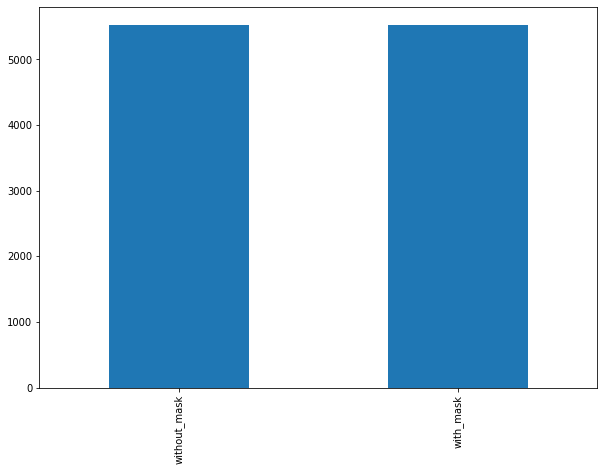

In [10]:
labels_csv['Label'].value_counts().plot.bar(figsize = (10, 7));

Storing the path of all images in a list

In [11]:
with_mask_filenames_temp = sorted_alphanumeric(os.listdir(os.path.join(DATASET_DIR, 'with_mask')))
# with_mask_filenames = [DATASET_DIR+'\\with_mask\\'+with_mask_filename for with_mask_filename in with_mask_filenames]
with_mask_filenames = []
for fn in with_mask_filenames_temp:
    with_mask_filenames.append(os.path.join(DATASET_DIR, "with_mask", fn))

without_mask_filenames_temp = sorted_alphanumeric(os.listdir(os.path.join(DATASET_DIR, 'without_mask')))
# without_mask_filenames = [DATASET_DIR+'\\without_mask\\'+without_mask_filename for without_mask_filename in without_mask_filenames]
without_mask_filenames = []
for fn in without_mask_filenames_temp:
    without_mask_filenames.append(os.path.join(DATASET_DIR, "without_mask", fn))

In [12]:
print("[INFO] loading images...")
imagePaths = with_mask_filenames + without_mask_filenames
imagePaths[:10]

[INFO] loading images...


['/home/shinjini/Shinjini/Coding/Random/MakeMIT 2021/Mask-Manager/Dataset/with_mask/0.jpg',
 '/home/shinjini/Shinjini/Coding/Random/MakeMIT 2021/Mask-Manager/Dataset/with_mask/1.jpg',
 '/home/shinjini/Shinjini/Coding/Random/MakeMIT 2021/Mask-Manager/Dataset/with_mask/2.jpg',
 '/home/shinjini/Shinjini/Coding/Random/MakeMIT 2021/Mask-Manager/Dataset/with_mask/3.jpg',
 '/home/shinjini/Shinjini/Coding/Random/MakeMIT 2021/Mask-Manager/Dataset/with_mask/4.jpg',
 '/home/shinjini/Shinjini/Coding/Random/MakeMIT 2021/Mask-Manager/Dataset/with_mask/5.jpg',
 '/home/shinjini/Shinjini/Coding/Random/MakeMIT 2021/Mask-Manager/Dataset/with_mask/6.jpg',
 '/home/shinjini/Shinjini/Coding/Random/MakeMIT 2021/Mask-Manager/Dataset/with_mask/7.jpg',
 '/home/shinjini/Shinjini/Coding/Random/MakeMIT 2021/Mask-Manager/Dataset/with_mask/8.jpg',
 '/home/shinjini/Shinjini/Coding/Random/MakeMIT 2021/Mask-Manager/Dataset/with_mask/9.jpg']

Visualizing images loaded using paths in above array

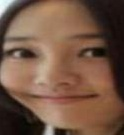

In [33]:
Image(imagePaths[8000])

Converting label colums to numpy array

In [14]:
labels = labels_csv['Label'].to_numpy()
labels, len(labels)

(array(['with_mask', 'with_mask', 'with_mask', ..., 'without_mask',
        'without_mask', 'without_mask'], dtype=object),
 11042)

Finding the unique_labels out of labels list

In [15]:
unique_labels = np.unique(labels)
unique_labels

array(['with_mask', 'without_mask'], dtype=object)

Turning labels array to a boolean array

In [16]:
boolean_labels = [label == unique_labels for label in labels]
np.array(boolean_labels).shape

(11042, 2)

Visualizing Data Batches

In [34]:
x = imagePaths
y = boolean_labels
print(y[8000])
NUM_IMAGES = len(imagePaths)

[False  True]


In [35]:
x[0]

'/home/shinjini/Shinjini/Coding/Random/MakeMIT 2021/Mask-Manager/Dataset/with_mask/0.jpg'

x = imagePaths
y = boolean_labels
print(len(x), len(y))
Image(x[3])
print(y[3])
NUM_IMAGES = len(imagePaths)

In [18]:
np.random.seed(42)
xTrain, xValid, yTrain, yValid = train_test_split(x[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2)
len(xTrain), len(xValid)

(8833, 2209)

In [19]:
IMG_SIZE = 224
def preprocessor(image_path, image_size = IMG_SIZE):
    '''
    Takes an image file path and turns it into a tensor, normalizes and reshapes it
    '''
    # Read an image file
    image = tf.io.read_file(image_path)
    # Turn the jpg image into a tensor with 3 color channels
    image = tf.image.decode_jpeg(image, channels = 3)
    # Normalization, from 0-255 to 0-1
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired values (60, 60)
    image = tf.image.resize(image, size = [IMG_SIZE, IMG_SIZE])
    return image

In [20]:
# Create a function to return (image, label)
def get_image_label(image_path, label):
    '''
    Takes image file path and the associated label as the imput and gives out
    the tuple of the two
    '''
    image = preprocessor(image_path)
    return image, label

In [51]:
# Creating a function to convert data into batches
def create_data_batches(x, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
    '''
    Creates batches of Data out of images x and labels y pairs.
    Shuffles the training data but not validation data
    Also accepts test data as input (without labels)
    '''

    if test_data:
        print('Creating Test Data Batches!')

        # Turn filepaths (images) into a list of tensors/slices a big  tensor into smaller objects
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))

        # Preprocess these sliced tensors(tensor for each image in file_names array) & batch them
        data_batch = data.map(preprocessor).batch(BATCH_SIZE)

        return data_batch

    elif valid_data:
        print('Creating Valid Data batches!')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                                   tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    else:
        print('Creating Training data batches!')
        y = np.array(y)
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                                   tf.constant(y)))
        # Shuffling pathnames and labels before mapping preprocessor function
        data = data.shuffle(buffer_size = len(x))

        data_batch = data.map(get_image_label).batch(BATCH_SIZE)

        return data_batch

In [59]:
# Creating training data batches
train_data = create_data_batches(xTrain, yTrain)

Creating Training data batches!


In [63]:
print(tf.__version__)

1.15.0


In [60]:
# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch.
    """
    # Setup the figure
    plt.figure(figsize=(10, 10))
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i+1)
        # Display an image 
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_labels[labels[i].argmax()])
        # Turn the grid lines off
        plt.axis("off")

In [61]:
train_images, train_labels = next(train_data.as_numpy_iterator())

AttributeError: 'DatasetV1Adapter' object has no attribute 'as_numpy_iterator'

In [58]:
show_25_images(train_images, train_labels)

NameError: name 'train_images' is not defined

Loading all images from dataset directory and storing them in a list. Also storing the classes for each image in seperate list.

In [28]:
data = []
labels = []

for imagePath in imagePaths:
    # Extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the input image (IMAGE_SIZExIMAGE_SIZE) and preprocess it
    image = load_img(imagePath, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(label)

Converting lists to numpy array for faster calculations

In [29]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

Perform One-Hot Encoding on the labels

In [30]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
np.array(labels).shape

(11042, 2)

Splitting the data intp train and test set (80% data for training and 20%data for testing

In [31]:
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  labels,
                                                  test_size=0.20,
                                                  stratify=labels,
                                                  random_state=42)

Define function for Image Augmentation, it also returns test and treain batches

In [32]:
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")

Function to create tensorboard callback

In [33]:
def create_tensorboard_callback():
    # Creating a log firectory for saving TensorBoard logs
    logdir = os.path.join('C:\\Users\\madan\\Projects\\SummerTraining\\Project\\Medical_Mask_Detection\\logs',
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    return tf.keras.callbacks.TensorBoard(logdir)

Creating Early Stopping Callback to avoid overfitting

In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy',
                                                  patience = 3)

Loading the base pretrained model of MobileNetV2

In [35]:
# load the MobileNetV2 network with the head layers
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
                        input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))

Constructing new head which will used on top of base model

In [36]:
# Construct new head for model which will be trained for our classification of masks
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Place the Head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# Set all layers of base model to non trainable
for layer in baseModel.layers:
    layer.trainable = False

Compile the model

In [37]:
print("[INFO] Compiling model...")

opt = Adam(lr=LR, decay=LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"]) # binary_crossentropy as ours is a binary classification

[INFO] Compiling model...


Train the head of the model

In [38]:
tensorboard = create_tensorboard_callback()

print("[INFO] Training head...")

H = model.fit(aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
              steps_per_epoch=len(trainX) // BATCH_SIZE,
              validation_data=(testX, testY),
              validation_steps=len(testX) // BATCH_SIZE,
              epochs=EPOCHS,
              callbacks = [tensorboard])

[INFO] Training head...
  ...
    to  
  ['...']
Train for 276 steps, validate on 2209 samples
Epoch 1/30
276/276 [==============================] - 105s 379ms/step - loss: 0.3107 - accuracy: 0.8644 - val_loss: 0.3352 - val_accuracy: 0.8913
Epoch 2/30
276/276 [==============================] - 108s 392ms/step - loss: 0.1502 - accuracy: 0.9452 - val_loss: 0.3708 - val_accuracy: 0.8918
Epoch 3/30
276/276 [==============================] - 117s 425ms/step - loss: 0.1247 - accuracy: 0.9580 - val_loss: 0.4453 - val_accuracy: 0.8786
Epoch 4/30
276/276 [==============================] - 120s 436ms/step - loss: 0.1018 - accuracy: 0.9642 - val_loss: 0.3111 - val_accuracy: 0.9185
Epoch 5/30
276/276 [==============================] - 122s 443ms/step - loss: 0.0920 - accuracy: 0.9676 - val_loss: 0.3077 - val_accuracy: 0.9207
Epoch 6/30
276/276 [==============================] - 119s 431ms/step - loss: 0.0879 - accuracy: 0.9691 - val_loss: 0.2720 - val_accuracy: 0.9280
Epoch 7/30
276/276 [=========

Making Predictions on test data and storing the model

In [39]:
# Make predictions
print("[INFO] Evaluating model...")
pred = model.predict(testX, batch_size=BATCH_SIZE)

# Get value of prediction with maximum probability
pred = np.argmax(pred, axis=1)

# show classification report
print(classification_report(testY.argmax(axis=1),
                            pred,
                            target_names=lb.classes_))

# Save model
print("[INFO] Saving model...")
model.save("maskdetector.model", save_format="h5")

[INFO] Evaluating model...
              precision    recall  f1-score   support

   with_mask       1.00      0.85      0.92      1104
without_mask       0.87      1.00      0.93      1105

    accuracy                           0.93      2209
   macro avg       0.93      0.93      0.92      2209
weighted avg       0.93      0.93      0.92      2209

[INFO] Saving model...


# Visualizing Results

Plotting Training losses and accuracies together

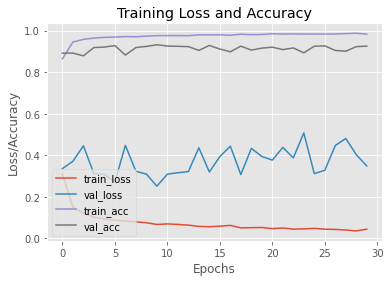

In [40]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("lossandacuracy.png")

Plotting Training Accuracies

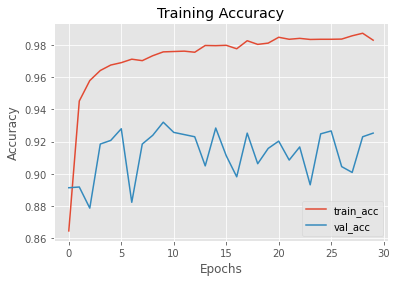

In [41]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig("accuracy.png")

Plotting Training Losses

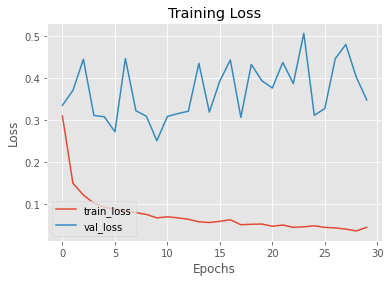

In [42]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("loss.png")

ROC curve ROC_AUC score

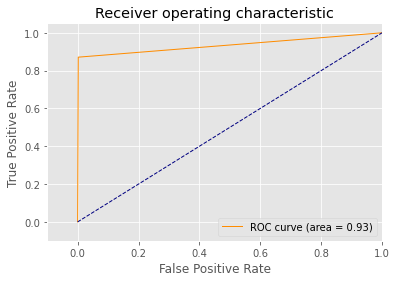

In [43]:
fpr, tpr, thresholds = roc_curve(pred, testY.argmax(axis=1)) 
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.show()
plt.savefig("Roc_curve.png")

Confusion Matrix

In [44]:
results = confusion_matrix(testY.argmax(axis=1), pred)

print(results)

[[ 941  163]
 [   2 1103]]


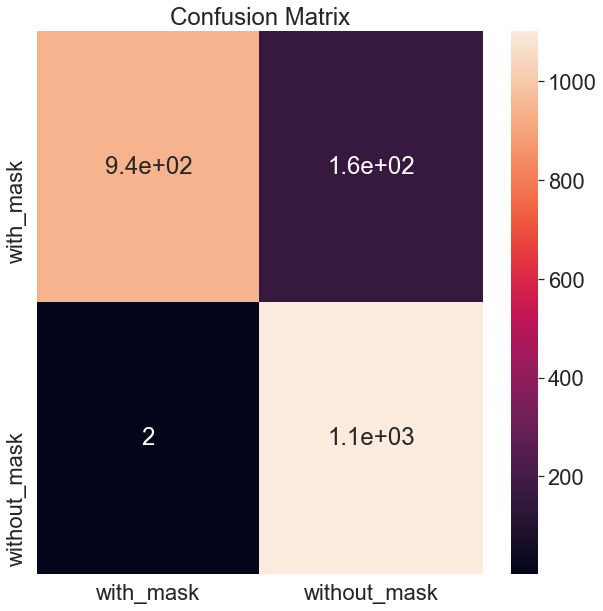

In [45]:
array = [[941,163],
         [2,1103]]
df_cm = pd.DataFrame(array, index = [i for i in classes],
                  columns = [i for i in classes])
sn.set(font_scale=2)
plt.figure(figsize = (10,10))
plt.title("Confusion Matrix")

sn.heatmap(df_cm, annot=True)
plt.savefig("cm.png")

# Classification on Static Images

Set path for face detector model files

In [46]:
PATH_FACEDETECTOR = input("Enter the path:") or "resnet_ssd_facedetector"

Enter the path:


Load face detector files and mask classification model

In [47]:
model = "maskdetector.model"
confidence_min = 0.5

# load face detector model from disk
print("[INFO] Loading face detector model...")
prototxtPath = os.path.sep.join([PATH_FACEDETECTOR, "deploy.prototxt"])
weightsPath = os.path.sep.join([PATH_FACEDETECTOR,"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] Loading mask detector model...")
model = load_model(model)

[INFO] Loading face detector model...
[INFO] Loading mask detector model...


Load image and construct blob

In [48]:
image = cv2.imread("testing\\test3.jpg")
original = image.copy()
(h, w) = image.shape[:2]

# Construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
                             (104.0, 177.0, 123.0))

Detect Face, Make predictions and give output

In [49]:
print("[INFO] Detecting faces...")
net.setInput(blob)
detections = net.forward()


for i in range(0, detections.shape[2]):
    # Extract the confidence associated with the detection
    confidence = detections[0, 0, i, 2]

    if confidence > confidence_min:
        # Compute the (x, y)-coordinates of the bounding box 
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # Ensure the bounding boxes fall within the dimensions of the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

        # Extract the face ROI, convert it from BGR to RGB channel, resize it to 224x224,
        # and preprocess it
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)

        # Make prediction
        (mask, withoutMask) = model.predict(face)[0]

        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # Include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # Display the label and bounding box rectangle on the output frame
        cv2.putText(image, label, (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 10)

# Show the output image
cv2.imshow("Output", image)
# Save image
cv2.imwrite(r"C:\Users\madan\Projects\SummerTraining\Project\Medical_Mask_Detection\Output_test\test3.jpg", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

[INFO] Detecting faces...


Visualize Predictions

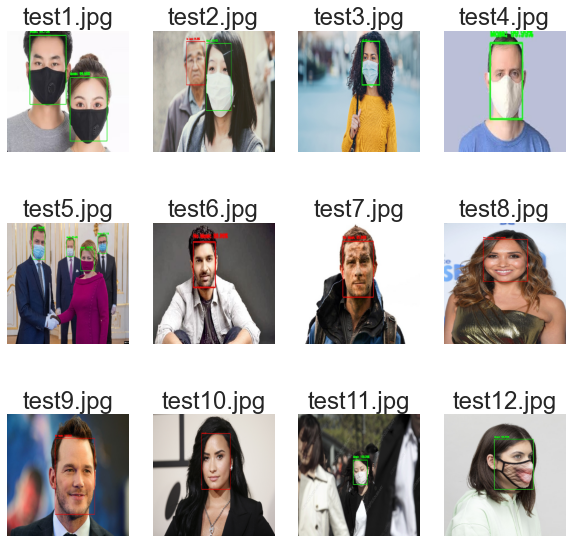

In [51]:
images = [r"C:\Users\madan\Projects\SummerTraining\Project\Medical_Mask_Detection\Output_test\test"+str(i)+".jpg" for i in range(1, 13)]

# Setup the figure
plt.figure(figsize=(10, 10))
for i in range(1, 13):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(3, 4, i)
    # Display an image 
    plt.imshow(load_img(images[i-1], target_size=(400, 400)))
    # Add the image label as the title
    plt.title(images[i-1].split("\\")[-1])
    # Turn the grid lines off
    plt.axis("off")
plt.savefig("collage.png")

# Classification on Real time feed

Set path for face detector model files

In [52]:
PATH_FACEDETECTOR = input("Enter the path:") or "resnet_ssd_facedetector"

Enter the path:


Load face detector files and mask classification model

In [53]:
model = "maskdetector.model"
confidence_min = 0.5

# load face detector model from disk
print("[INFO] Loading face detector model...")
prototxtPath = os.path.sep.join([PATH_FACEDETECTOR, "deploy.prototxt"])
weightsPath = os.path.sep.join([PATH_FACEDETECTOR,"res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] Loading mask detector model...")
model = load_model(model)

[INFO] Loading face detector model...
[INFO] Loading mask detector model...


In [54]:
def detect_and_predict_mask(frame, faceNet, maskNet):
    # Construct blob
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
                                 (104.0, 177.0, 123.0))

    # Face Detction
    faceNet.setInput(blob)
    detections = faceNet.forward()

    # initialize list of faces, their locations and their predictions
    faces = []
    locs = []
    preds = []

    for i in range(0, detections.shape[2]):
        # Extract the confidence associated with the detection
        confidence = detections[0, 0, i, 2]

        if confidence > confidence_min:
            # compute the (x, y)-coordinates of the bounding box
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # Extract the face ROI, convert it from BGR to RGB channel, resize it to 224x224,
            # and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)

            # Add the face and bounding boxes to their respective lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # Make predictions when detected faces are more than one
    if len(faces) > 0:
        preds = maskNet.predict(faces)
        
    return (locs, preds)

Initialise Capturing real time video and make detections

In [56]:
# Initialize the video stream with little delay
print("[INFO] Start video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)

while True:
    # Grab the frame from the threaded video stream and resize it
    frame = vs.read()
    frame = imutils.resize(frame, width=400)

    # Detect faces and make predictions
    (locs, preds) = detect_and_predict_mask(frame, faceNet, model)

    # Loop over the detected face locations and their corresponding locations
    for (box, pred) in zip(locs, preds):
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # Include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # display the label and bounding box rectangle on the output frame
        cv2.putText(frame, label, (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    # Show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    # Press q for quitting
    if key == ord("q"):
        break

cv2.destroyAllWindows()
vs.stop()

[INFO] Start video stream...
